<a href="https://colab.research.google.com/github/JuliethLopez/chatbot_simpsons/blob/master/Clasificador%20frases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación usando Lenguaje Natural

In [0]:
#librerias
import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define algunas características iniciales

In [0]:
vocab_size = 2000 # número de palabras que integrarán el vocabulario
embedding_dim = 32 # dimensión del embeding de las palabras
max_length = 120  # longitud máxima de una oración (sentence filtrada con stopwords)
trunc_type='post' # donde truncar una oración (sentence, filtrada con stopwords)
padding_type='post'# donde hacer el padding (agregar ceros) en una oración (sentence, filtrada con stopwords)
oov_tok = "<OOV>"  # token para las palabras que queden fuera del vocabulario
training_portion = .8  # porcentaje de datos para entrenamiento

In [3]:
complete_sentences = []
complete_lines = [] 
sentences = []
labels = [] # preprocesed labels

stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))

153


In [4]:
import string
import numpy as np

a = np.array([32]) # space
#b = np.array(range(65,91)) # uppercase
c = np.array(range(97,123)) # lowercase
printab = np.hstack((a,c))

printable = np.array([chr(i) for i in printab])   
printable

#ascci_to_char = dict((printab[i], printable[i]) for i in range(len(printable)))

array([' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
       'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
       'z'], dtype='<U1')

In [5]:
#lectura de los datos
import string
import re #regular expresions
# abre el archivo de datos y lo trata como un archivo csv
file = open('DFSMS.csv', 'r')
with file as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        # preprocess label
        #label_l = ' '.join(row[0].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
        label_l = re.sub(' +', ' ',row[0].lower()) # lower case ans eliminate multiple spaces
        if (len(label_l)>2): # drop with empty label
            label = ''.join(c for c in label_l if c in printable)# filter only printable characters
            label = label.replace(' ','_')
            labels.append(label)
            # preprocess sentence
            #sentence_l = ' '.join(row[1].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
            sentence_l = re.sub(' +', ' ',row[1].lower())
            sentence = ''.join(c for c in sentence_l if c in printable)
            complete_lines.append(row[0] + ': '+ row[1])
            complete_sentences.append(sentence)
            # preprocess stopwords
            for word in stopwords:
                token = " " + word + " "
                sentence = sentence.replace(token, " ")
            sentences.append(sentence)
 

# resumen de la lectura            
print(len(labels))
print(len(complete_sentences))
print(len(complete_lines))
print(len(sentences))
# Expected Output
# 158314

69171
69171
69171
69171


In [6]:
# primera linea
print(labels[0]+'\n')
print(complete_sentences[0]+'\n')
print(complete_lines[0]+'\n')
print(sentences[0]+'\n')
# Expected Output
# 158314
# 158314

lisa_simpson

wheres mr bergstrom

Lisa Simpson: Where's Mr. Bergstrom?

wheres mr bergstrom



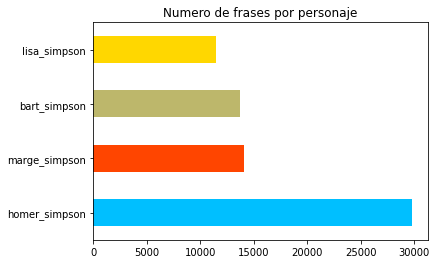

In [152]:
#Gráfico de barras de numero de frases por personaje
frec = pd.value_counts(labels)
plot = frec.plot(kind='barh',title='Numero de frases por personaje',color=['deepskyblue','orangered','darkkhaki','gold'])

In [25]:
sentences[:4]

['wheres mr bergstrom',
 'that life worth living',
 'victory party slide',
 'mr bergstrom mr bergstrom']

# Separa datos de entrenamiento y validación 

In [26]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

# Expected output (if training_portion=.8)
# 126651 train
# 31663 validation

55336
55336
55336
13835
13835


In [27]:
train_sentences[:3]

['wheres mr bergstrom', 'that life worth living', 'victory party slide']

In [28]:
train_labels[:3]

['lisa_simpson', 'lisa_simpson', 'bart_simpson']

# crea el vocabulario

In [0]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok,split= ' ')
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = np.array(pad_sequences(train_sequences, padding=padding_type, maxlen=max_length))

In [30]:
print((train_sequences[0]))
print(len(train_padded[0]))

#print(len(train_sequences[1]))
#print(len(train_padded[1]))

#print(len(train_sequences[10]))
#print(len(train_padded[10]))

# Expected Ouput
# 12
# 120
# 3
# 120
# 10
# 120

[316, 89, 1]
120


In [31]:
train_sequences[:2]

[[316, 89, 1], [50, 100, 774, 530]]

In [32]:
train_padded[:2]

array([[316,  89,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [ 50, 100, 774, 530,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,

In [0]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = np.array(pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length))


In [34]:
validation_sequences[:2]

# Expected output
# 31663
# (31663, 120)

[[], [203, 1, 1, 32, 39]]

In [35]:
validation_padded[:2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [203,   1,   1,  32,  39,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,

In [36]:
print(len(validation_sequences))
print(validation_padded.shape)

# Expected output
# 31663
# (31663, 120)

13835
(13835, 120)


In [37]:
label_size = 500
#filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
label_tokenizer = Tokenizer(num_words = label_size,oov_token=oov_tok, filters = '')
label_tokenizer.fit_on_texts(labels)

label_seq = np.array(label_tokenizer.texts_to_sequences(labels))
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq[3])
print(training_label_seq[5])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq[3])
print(validation_label_seq[5])
print(validation_label_seq.shape)

# Expected output
# [4]
# [2]
# [1]
# (1780, 1)
# [5]
# [4]
# [3]
# (445, 1)

[5]
[5]
[4]
[5]
[5]
(55336, 1)
[2]
[2]
[2]
[2]
[4]
(13835, 1)


In [0]:
# flatten the nested list and tranaform to an np array
label_seq = np.array([item for items in label_seq for item in items])
training_label_seq = np.array([item for items in training_label_seq for item in items])
validation_label_seq = np.array([item for items in validation_label_seq for item in items])


In [39]:
label_seq[:5]

array([5, 5, 4, 5, 5])

In [40]:
max(validation_label_seq)

5

# transform target to one-hot codification

## primero crea etiquetas numéricas

In [0]:
from sklearn. preprocessing import LabelEncoder
#preprocessing.LabelEncoder()
encoder = LabelEncoder()

encoder.fit(label_seq)
y_train = encoder.transform(training_label_seq)
y_test = encoder.transform(validation_label_seq)

In [42]:
max(y_train)

3

In [43]:
y_train.shape

(55336,)

In [44]:
y_train

array([3, 3, 2, ..., 0, 0, 1])

In [45]:
y_test

array([0, 0, 0, ..., 1, 3, 3])

## one hot

In [0]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [47]:
num_classes

4

In [48]:
y_train.shape

(55336, 4)

In [49]:
y_train[0]

array([0., 0., 0., 1.], dtype=float32)

In [50]:
y_test[0]

array([1., 0., 0., 0.], dtype=float32)

## Modelo 1

| dropout | conv1D | LSTM | accuracyTrain | accuracyValidation | epoch |
|---------|:------:|:----:|:-------------:|:------------------:|:-----:|
|         |        |      |    0.3645     |       0.3478       |  13   |
|    1    |   1    |      |    0.3751     |       0.3462       |  11   |
|         |   1    |      |    0.3761     |       0.3455       |  10   |
|    1    |        |      |    0.3668     |       0.3527       |  15   |
|    1    |        |   1  |    0.3730     |       0.3416       |  13   |

## Modelo 2 con 9 Labels

| spatial Dropout1d | BIDLSTM | Dropout | Dense | lossTrain |accuracyTrain | accuracyValidation | lossValidation  | epoch |
|::|::|::|::|::|::|::|::|::|
|1|2|2|2|1.2943|0.5236|1.5963|0.4304|23|



## Modelo 3 con 4 Labels - 20 ephocs

| Conv1D | SpatialDroout1D | BIDLSTM | Dropout | Densa | lossTrain |accuracyTrain | accuracyValidation | lossValidation  | epoch |
|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
| | |1|2|2|1.0705|0.5387|1.1504|0.4953|10|
|1|1||2|2|1.0209|0.5645|1.1661|0.4930|7|
|1||1|2|2|1.0497|0.5510|1.1570|0.4941|5|
||1|1|2|2|1.0601|0.5453|1.1625|0.4911|9|
|1|1|1|2|2|1.0479|0.5516|1.1565|0.4898|6|
|2| | |2|2|1.0265|0.5626|1.1968|0.4835|6|
| | | |2|2|1.0691|0.5402|1.1626|0.4978|10|
| | | |3|3|1.0789|0.5394|1.1517|0.4966|11|

In [0]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=3
    )
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

In [153]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(120, return_sequences=True)),
    #tf.keras.layers.SpatialDropout1D(rate=0.1),
    #tf.keras.layers.Conv1D(128, 5, activation='relu'),
    #tf.keras.layers.Conv1D(126, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 120, 32)           64000     
_________________________________________________________________
global_average_pooling1d_21  (None, 32)                0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               4224      
_________________________________________________________________
dropout_44 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 4)                 516       
Total params: 68,740
Trainable params: 68,740
Non-trainable params: 0
_________________________________________________

## Entrenamos el modelo

In [154]:
num_epochs = 40
history = model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(validation_padded, y_test), verbose=2, callbacks=[callback])
print("\nEn la epoca", len(history.history['val_accuracy']), "la precision de validación dejó de mejorar.")

Epoch 1/40
1730/1730 - 9s - loss: 1.2872 - accuracy: 0.4369 - val_loss: 1.2343 - val_accuracy: 0.4595
Epoch 2/40
1730/1730 - 9s - loss: 1.1832 - accuracy: 0.4883 - val_loss: 1.1695 - val_accuracy: 0.4858
Epoch 3/40
1730/1730 - 9s - loss: 1.1368 - accuracy: 0.5083 - val_loss: 1.1513 - val_accuracy: 0.4945
Epoch 4/40
1730/1730 - 9s - loss: 1.1204 - accuracy: 0.5159 - val_loss: 1.1540 - val_accuracy: 0.4873
Epoch 5/40
1730/1730 - 9s - loss: 1.1083 - accuracy: 0.5226 - val_loss: 1.1405 - val_accuracy: 0.4988
Epoch 6/40
1730/1730 - 9s - loss: 1.0987 - accuracy: 0.5267 - val_loss: 1.1443 - val_accuracy: 0.4969
Epoch 7/40
1730/1730 - 9s - loss: 1.0887 - accuracy: 0.5326 - val_loss: 1.1388 - val_accuracy: 0.4972
Epoch 8/40
1730/1730 - 9s - loss: 1.0834 - accuracy: 0.5333 - val_loss: 1.1406 - val_accuracy: 0.4977

En la epoca 8 la precision de validación dejó de mejorar.


## Graficamos

In [155]:
string='accuracy'
print(history.history[string])
print(history.history['val_'+string])

[0.43685847520828247, 0.48825356364250183, 0.5083309412002563, 0.5158847570419312, 0.5226073265075684, 0.5267095565795898, 0.5326188802719116, 0.5332514047622681]
[0.45948681235313416, 0.48579689860343933, 0.4944705367088318, 0.48731479048728943, 0.4988073706626892, 0.49685579538345337, 0.49721720814704895, 0.49772316217422485]


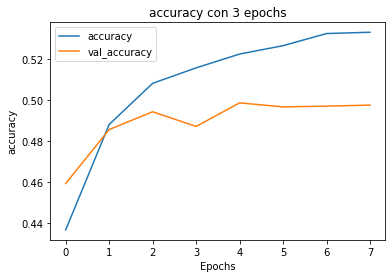

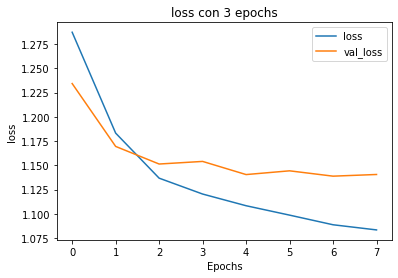

In [156]:
def plot_graphs(history, string):
  plt.title(string+' con 3 epochs')
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [157]:
#convierte palabras en texto (NO LO USAMOS AÚN)
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_sentence([862, 54])

'space take'

In [158]:
#Pesos de la primera capa
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

# Expected output
# (1000, 16)

(2000, 32)


In [159]:
weights

array([[ 1.3207152e-03, -4.0298142e-03,  2.7255244e-03, ...,
         1.2001265e-03, -4.3367883e-04,  3.5872199e-03],
       [-5.6424953e-02,  2.0323945e-02, -4.0263299e-02, ...,
         3.5518002e-02, -6.6926926e-03,  3.6769111e-02],
       [ 1.9128922e-02, -5.5823818e-02,  4.2800460e-02, ...,
         7.0338242e-02,  1.0285718e-01,  1.3780163e-02],
       ...,
       [-2.3485972e-01, -6.0637802e-01,  5.5748069e-01, ...,
         3.8384771e-01,  4.1087204e-01, -6.7826711e-02],
       [ 1.2541239e-01, -3.8065788e-01,  2.4860275e-01, ...,
        -1.8706484e-02,  3.1570200e-02, -4.7936940e-01],
       [-2.1636237e-01,  1.6926812e-01, -2.5391337e-01, ...,
         9.0377025e-02,  1.5779184e-02, -1.6843896e-02]], dtype=float32)

## funcion clasificadora

In [160]:
validation_sentences[:2]

['', 'someone snitched whawhawhawhawhat gonna me']

In [161]:
sq = model.predict_classes(validation_padded[:2])
sq

array([0, 0])

In [162]:
label_tokenizer.sequences_to_texts([sq])

['<OOV> <OOV>']

In [0]:
def classifier (sentence): 
  sentences = []
  sentence_l = re.sub(' +', ' ',sentence.lower())
  sentence = ''.join(c for c in sentence_l if c in printable)
  # preprocess stopwords
  for word in stopwords:
    token = " " + word + " "
    sentence = sentence.replace(token, " ")
  sentences.append(sentence)

  sentences = tokenizer.texts_to_sequences(sentences) #transforms each text in texts to a sequence of integers
  sentences_padded = np.array(pad_sequences(sentences, padding=padding_type, maxlen=max_length))

  #prob = model.predict(sentences_padded)
  prediction = model.predict_classes(sentences_padded)
  prediction = label_tokenizer.sequences_to_texts([prediction])

  return prediction

In [164]:
classifier('are you sure lord')

['<OOV>']

In [165]:
classifier('can his funeral be on a school day')

['homer_simpson']

In [166]:
classifier("We should go to the bar")

['<OOV>']

## exportar archivos

In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Referencias
- Aprendizaje profundo, [Ciencia de datos](https://github.com/AprendizajeProfundo/Ciencia-de-Datos/tree/master/Cuadernos)